In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointListFull,getDataPointList,DataPoint
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceAI_10K
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d
from src.gpu_metrics import run_bootstrap

In [2]:
rng = np.random.default_rng(23673)

In [3]:
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS
k = k*NUM_ACCUMULATION_STEPS

CL = 2 * np.sum(AR*(W-1))



In [ ]:
data_dir = '../Data'
setType = 'train'
annotation, transcriptToLabel, seqData = getData(data_dir, setType)

In [4]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number

CL_max=10000
SL=5000

In [6]:
assert CL_max % 2 == 0

In [7]:
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]

In [8]:
train_dataset = spliceDataset(getDataPointListFull(annotation_train,transcriptToLabel,SL,CL_max,shift=SL))
val_dataset = spliceDataset(getDataPointListFull(annotation_validation,transcriptToLabel,SL,CL_max,shift=SL))
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

In [9]:
tmp = getDataPointListFull(annotation_train,transcriptToLabel,SL,CL_max,shift=SL)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
hs = []
learning_rate= k*1e-3
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 
gamma = 0.5

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:23<00:00,  4.36it/s, a_r=0.868, d_r=0.884, loss=0.000212]


epoch: 1/10, train loss = 0.011998


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:16<00:00,  4.41it/s, a_r=0.892, d_r=0.902, loss=0.000192]


epoch: 2/10, train loss = 0.000197


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:15<00:00,  4.41it/s, a_r=0.905, d_r=0.912, loss=0.000174]


epoch: 3/10, train loss = 0.000180


Epoch (train) 4/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.91, d_r=0.921, loss=0.000168]


epoch: 4/10, train loss = 0.000167


Epoch (train) 5/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:18<00:00,  4.39it/s, a_r=0.92, d_r=0.932, loss=0.000154]


epoch: 5/10, train loss = 0.000153


Epoch (train) 6/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:16<00:00,  4.41it/s, a_r=0.928, d_r=0.939, loss=0.000137]


epoch: 6/10, train loss = 0.000141


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.945, d_r=0.952, loss=0.000113]


epoch: 7/10, train loss = 0.000111


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:15<00:00,  4.42it/s, a_r=0.957, d_r=0.964, loss=9.41e-5]


epoch: 8/10, train loss = 0.000092


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:14<00:00,  4.42it/s, a_r=0.965, d_r=0.969, loss=8.15e-5]


epoch: 9/10, train loss = 0.000079


Epoch (train) 10/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.972, d_r=0.973, loss=6.84e-5]


epoch: 10/10, train loss = 0.000071


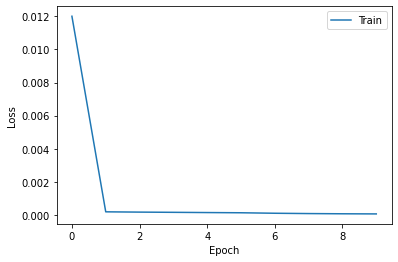

Epoch (train) 1/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:20<00:00,  4.38it/s, a_r=0.858, d_r=0.879, loss=0.00022]


epoch: 1/10, train loss = 0.012054


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:21<00:00,  4.37it/s, a_r=0.889, d_r=0.903, loss=0.000195]


epoch: 2/10, train loss = 0.000202


Epoch (train) 3/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:20<00:00,  4.38it/s, a_r=0.906, d_r=0.91, loss=0.000177]


epoch: 3/10, train loss = 0.000181


Epoch (train) 4/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:18<00:00,  4.39it/s, a_r=0.91, d_r=0.92, loss=0.000162]


epoch: 4/10, train loss = 0.000168


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:15<00:00,  4.42it/s, a_r=0.921, d_r=0.926, loss=0.000154]


epoch: 5/10, train loss = 0.000155


Epoch (train) 6/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.93, d_r=0.935, loss=0.000146]


epoch: 6/10, train loss = 0.000142


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.949, d_r=0.953, loss=0.000113]


epoch: 7/10, train loss = 0.000113


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:19<00:00,  4.39it/s, a_r=0.959, d_r=0.964, loss=9.09e-5]


epoch: 8/10, train loss = 0.000094


Epoch (train) 9/10: 100%|██████████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.965, d_r=0.967, loss=8e-5]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.968, d_r=0.971, loss=7.35e-5]

epoch: 10/10, train loss = 0.000073


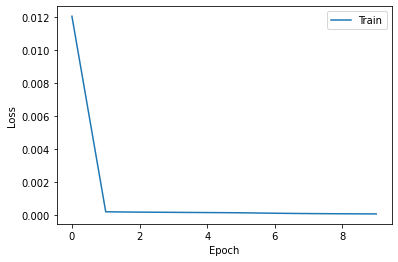

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:16<00:00,  4.40it/s, a_r=0.864, d_r=0.879, loss=0.000225]


epoch: 1/10, train loss = 0.011768


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.888, d_r=0.904, loss=0.000189]


epoch: 2/10, train loss = 0.000199


Epoch (train) 3/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.897, d_r=0.907, loss=0.00018]


epoch: 3/10, train loss = 0.000179


Epoch (train) 4/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:16<00:00,  4.40it/s, a_r=0.912, d_r=0.922, loss=0.000171]


epoch: 4/10, train loss = 0.000167


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:16<00:00,  4.41it/s, a_r=0.924, d_r=0.932, loss=0.000151]


epoch: 5/10, train loss = 0.000154


Epoch (train) 6/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:18<00:00,  4.39it/s, a_r=0.928, d_r=0.934, loss=0.000144]


epoch: 6/10, train loss = 0.000141


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:19<00:00,  4.38it/s, a_r=0.947, d_r=0.953, loss=0.000114]


epoch: 7/10, train loss = 0.000112


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.958, d_r=0.963, loss=9.13e-5]


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.965, d_r=0.969, loss=8.48e-5]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:18<00:00,  4.39it/s, a_r=0.966, d_r=0.97, loss=8.05e-5]

epoch: 10/10, train loss = 0.000073


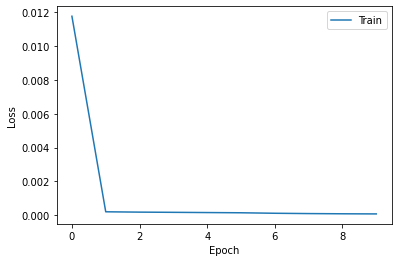

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:19<00:00,  4.38it/s, a_r=0.859, d_r=0.876, loss=0.000229]


epoch: 1/10, train loss = 0.011369


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:21<00:00,  4.37it/s, a_r=0.888, d_r=0.901, loss=0.000197]


epoch: 2/10, train loss = 0.000201


Epoch (train) 3/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:20<00:00,  4.38it/s, a_r=0.899, d_r=0.91, loss=0.000182]


epoch: 3/10, train loss = 0.000180


Epoch (train) 4/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:20<00:00,  4.38it/s, a_r=0.915, d_r=0.922, loss=0.00016]


epoch: 4/10, train loss = 0.000167


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:23<00:00,  4.36it/s, a_r=0.922, d_r=0.928, loss=0.000155]


epoch: 5/10, train loss = 0.000153


Epoch (train) 6/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:23<00:00,  4.36it/s, a_r=0.931, d_r=0.936, loss=0.00014]


epoch: 6/10, train loss = 0.000140


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:22<00:00,  4.36it/s, a_r=0.946, d_r=0.952, loss=0.000113]


epoch: 7/10, train loss = 0.000112


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:19<00:00,  4.38it/s, a_r=0.962, d_r=0.965, loss=9.09e-5]


epoch: 8/10, train loss = 0.000094


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:20<00:00,  4.38it/s, a_r=0.962, d_r=0.968, loss=8.16e-5]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:20<00:00,  4.38it/s, a_r=0.97, d_r=0.972, loss=7.27e-5]

epoch: 10/10, train loss = 0.000073


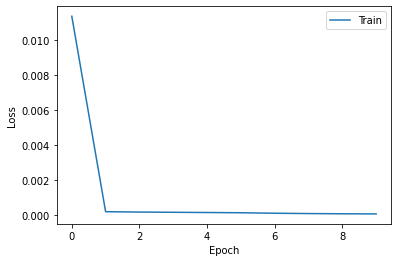

Epoch (train) 1/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:17<00:00,  4.40it/s, a_r=0.86, d_r=0.873, loss=0.00022]


epoch: 1/10, train loss = 0.012356


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:21<00:00,  4.37it/s, a_r=0.891, d_r=0.904, loss=0.000185]


epoch: 2/10, train loss = 0.000199


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:21<00:00,  4.37it/s, a_r=0.905, d_r=0.911, loss=0.000179]


epoch: 3/10, train loss = 0.000179


Epoch (train) 4/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:15<00:00,  4.41it/s, a_r=0.914, d_r=0.925, loss=0.000162]


epoch: 4/10, train loss = 0.000167


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:06<00:00,  4.48it/s, a_r=0.922, d_r=0.928, loss=0.000144]


epoch: 5/10, train loss = 0.000154


Epoch (train) 6/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.931, d_r=0.936, loss=0.000144]


epoch: 6/10, train loss = 0.000141


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.948, d_r=0.955, loss=0.000116]


epoch: 7/10, train loss = 0.000112


Epoch (train) 8/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.96, d_r=0.964, loss=9.43e-5]


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.962, d_r=0.968, loss=8.33e-5]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.965, d_r=0.97, loss=7.92e-5]

epoch: 10/10, train loss = 0.000072


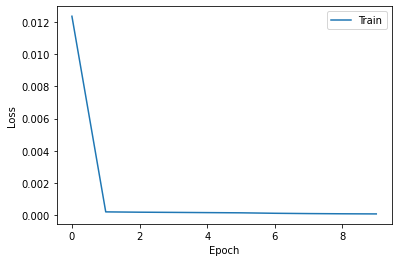

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:06<00:00,  4.48it/s, a_r=0.864, d_r=0.877, loss=0.000225]


epoch: 1/10, train loss = 0.010538


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.891, d_r=0.909, loss=0.000185]


epoch: 2/10, train loss = 0.000198


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.46it/s, a_r=0.902, d_r=0.911, loss=0.000181]


epoch: 3/10, train loss = 0.000180


Epoch (train) 4/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.46it/s, a_r=0.917, d_r=0.922, loss=0.00016]


epoch: 4/10, train loss = 0.000166


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.46it/s, a_r=0.923, d_r=0.928, loss=0.000146]


epoch: 5/10, train loss = 0.000154


Epoch (train) 6/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.47it/s, a_r=0.931, d_r=0.939, loss=0.000143]


epoch: 6/10, train loss = 0.000140


Epoch (train) 7/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:06<00:00,  4.48it/s, a_r=0.949, d_r=0.952, loss=0.00011]


epoch: 7/10, train loss = 0.000110


Epoch (train) 8/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.96, d_r=0.962, loss=8.84e-5]


epoch: 8/10, train loss = 0.000091


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.46it/s, a_r=0.961, d_r=0.968, loss=8.14e-5]


epoch: 9/10, train loss = 0.000077


Epoch (train) 10/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.47it/s, a_r=0.969, d_r=0.971, loss=7.18e-5]

epoch: 10/10, train loss = 0.000067


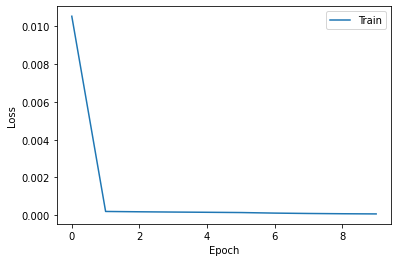

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.46it/s, a_r=0.863, d_r=0.877, loss=0.000214]


epoch: 1/10, train loss = 0.011627


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.895, d_r=0.902, loss=0.000181]


epoch: 2/10, train loss = 0.000200


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.47it/s, a_r=0.903, d_r=0.914, loss=0.000173]


epoch: 3/10, train loss = 0.000180


Epoch (train) 4/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:06<00:00,  4.48it/s, a_r=0.909, d_r=0.92, loss=0.000169]


epoch: 4/10, train loss = 0.000168


Epoch (train) 5/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.45it/s, a_r=0.921, d_r=0.93, loss=0.000151]


epoch: 5/10, train loss = 0.000155


Epoch (train) 6/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.927, d_r=0.936, loss=0.000143]


epoch: 6/10, train loss = 0.000142


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.46it/s, a_r=0.945, d_r=0.952, loss=0.000114]


epoch: 7/10, train loss = 0.000112


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:06<00:00,  4.48it/s, a_r=0.961, d_r=0.963, loss=9.07e-5]


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.966, d_r=0.969, loss=7.86e-5]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.967, d_r=0.973, loss=7.12e-5]

epoch: 10/10, train loss = 0.000073


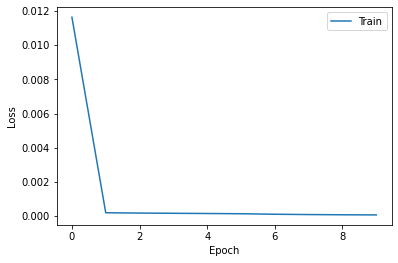

Epoch (train) 1/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:12<00:00,  4.44it/s, a_r=0.866, d_r=0.877, loss=0.00022]


epoch: 1/10, train loss = 0.011028


Epoch (train) 2/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:11<00:00,  4.44it/s, a_r=0.887, d_r=0.901, loss=0.00019]


epoch: 2/10, train loss = 0.000198


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.908, d_r=0.915, loss=0.000167]


epoch: 3/10, train loss = 0.000178


Epoch (train) 4/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.91, d_r=0.92, loss=0.000168]


epoch: 4/10, train loss = 0.000166


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:06<00:00,  4.48it/s, a_r=0.921, d_r=0.929, loss=0.000153]


epoch: 5/10, train loss = 0.000152


Epoch (train) 6/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.46it/s, a_r=0.931, d_r=0.938, loss=0.000134]


epoch: 6/10, train loss = 0.000139


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.949, d_r=0.952, loss=0.000111]


epoch: 7/10, train loss = 0.000110


Epoch (train) 8/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:12<00:00,  4.43it/s, a_r=0.96, d_r=0.963, loss=9.33e-5]


epoch: 8/10, train loss = 0.000091


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.964, d_r=0.968, loss=8.29e-5]


epoch: 9/10, train loss = 0.000078


Epoch (train) 10/10: 100%|██████████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.969, d_r=0.97, loss=7e-5]

epoch: 10/10, train loss = 0.000070


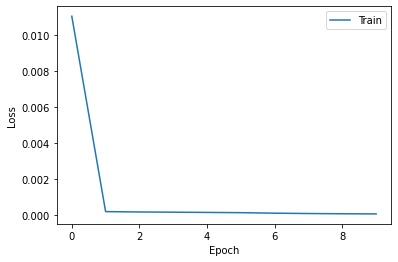

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.45it/s, a_r=0.864, d_r=0.886, loss=0.000214]


epoch: 1/10, train loss = 0.011707


Epoch (train) 2/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.46it/s, a_r=0.89, d_r=0.902, loss=0.000188]


epoch: 2/10, train loss = 0.000199


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.45it/s, a_r=0.899, d_r=0.911, loss=0.000178]


epoch: 3/10, train loss = 0.000181


Epoch (train) 4/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:11<00:00,  4.44it/s, a_r=0.913, d_r=0.922, loss=0.000162]


epoch: 4/10, train loss = 0.000168


Epoch (train) 5/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.46it/s, a_r=0.92, d_r=0.93, loss=0.000154]


epoch: 5/10, train loss = 0.000155


Epoch (train) 6/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.927, d_r=0.938, loss=0.00014]


epoch: 6/10, train loss = 0.000141


Epoch (train) 7/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.45it/s, a_r=0.949, d_r=0.954, loss=0.000111]


epoch: 7/10, train loss = 0.000113


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.47it/s, a_r=0.955, d_r=0.961, loss=9.99e-5]


epoch: 8/10, train loss = 0.000094


Epoch (train) 9/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:07<00:00,  4.47it/s, a_r=0.965, d_r=0.968, loss=8.04e-5]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:11<00:00,  4.44it/s, a_r=0.967, d_r=0.972, loss=7.39e-5]

epoch: 10/10, train loss = 0.000073


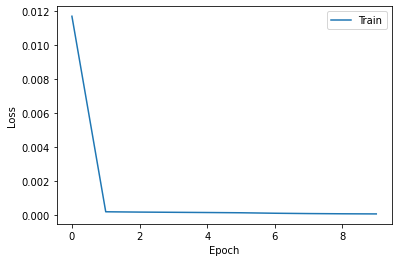

Epoch (train) 1/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:11<00:00,  4.44it/s, a_r=0.861, d_r=0.878, loss=0.000223]


epoch: 1/10, train loss = 0.012378


Epoch (train) 2/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:11<00:00,  4.44it/s, a_r=0.889, d_r=0.899, loss=0.000189]


epoch: 2/10, train loss = 0.000200


Epoch (train) 3/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.45it/s, a_r=0.899, d_r=0.911, loss=0.000176]


epoch: 3/10, train loss = 0.000181


Epoch (train) 4/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.912, d_r=0.92, loss=0.000162]


epoch: 4/10, train loss = 0.000168


Epoch (train) 5/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:10<00:00,  4.45it/s, a_r=0.923, d_r=0.929, loss=0.000152]


epoch: 5/10, train loss = 0.000155


Epoch (train) 6/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.45it/s, a_r=0.929, d_r=0.937, loss=0.00014]


epoch: 6/10, train loss = 0.000142


Epoch (train) 7/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:08<00:00,  4.46it/s, a_r=0.95, d_r=0.955, loss=0.000107]


epoch: 7/10, train loss = 0.000112


Epoch (train) 8/10: 100%|███████████████████████████████████████████████| 2716/2716 [10:11<00:00,  4.44it/s, a_r=0.958, d_r=0.963, loss=9.41e-5]


epoch: 8/10, train loss = 0.000094


Epoch (train) 9/10: 100%|████████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.46it/s, a_r=0.965, d_r=0.97, loss=8.34e-5]


epoch: 9/10, train loss = 0.000082


Epoch (train) 10/10: 100%|██████████████████████████████████████████████| 2716/2716 [10:09<00:00,  4.46it/s, a_r=0.969, d_r=0.973, loss=7.33e-5]

epoch: 10/10, train loss = 0.000074


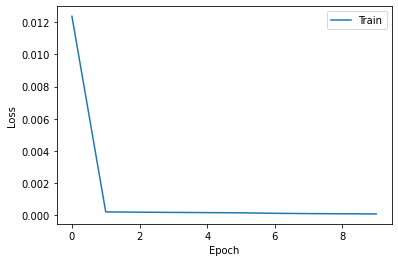

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
hs = []

for model_nr in range(10):
    model_m = SpliceAI_10K(CL_max)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    modelFileName = '../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(model_nr)
    #model_m.load_state_dict(torch.load('../Results/PyTorch_Models/SpliceAI_Ensembl_dgxtest_{}'.format(0)))
    #loss = nn.CrossEntropyLoss(weight=torch.from_numpy(weights).float().to(device),ignore_index=-1,reduction='mean')
    loss = categorical_crossentropy_2d().loss
    learning_rate= k*1e-3
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    #optimizer = torch.optim.Adam(model_m.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)
    h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,CL_max=CL_max,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,reinforce=False)
    hs.append(h)
    #print(model_m.module.conv_final.bias)
    #val_results_combined.append(val_results)
    plt.plot(range(epochs),h['loss'],label='Train')
    #plt.plot(range(epochs),h['val_loss'],label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
def odds_gmean(prediction,n_models,a = 1.5):
    p = torch.pow(torch.prod(prediction,dim=0), a/n_models)
    p_neg = torch.pow(torch.prod(1-prediction,dim=0), a/n_models)
    return p / (p+p_neg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/SpliceAITrainingCode/dataset_test_0_10k.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features).detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs),n_models)
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:28<00:00,  9.25s/it]


In [14]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00019534379481217815

Acceptor:
0.9952	0.946	0.9866	0.9906	0.9757	0.9768	0.3300	0.0025	0.0003	13517	14289.0	14289

Donor:
0.9945	0.9503	0.989	0.9925	0.978	0.9787	0.3324	0.0019	0.0002	13579	14289.0	14289


In [6]:
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)

In [7]:
run_bootstrap(Y_true_acceptor.astype(np.int8),Y_pred_acceptor.astype(np.float32),Y_true_donor.astype(np.int8),Y_pred_donor.astype(np.float32),n_bootstraps = 1000)

0.948141927356708 0.9768214821815491


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:46<00:00,  3.49it/s]

average precision score = 0.9768214821815491 (95% confidence interval: [0.9753254666924477, 0.9782778553664684])
topk score = 0.948141927356708 (95% confidence interval: [0.946229485074824, 0.9500070639238267])


In [15]:
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData(data_dir, setType)

In [5]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10


Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features).detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    #outputs = odds_gmean(torch.stack(outputs),n_models)
    outputs = torch.mean(torch.stack(outputs),dim=0)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())



NameError: name 'annotation_test' is not defined

In [17]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00011295254796592758

Acceptor:
0.9788	0.9369	0.9908	0.9953	0.9635	0.9798	0.4598	0.0028	0.0004	84052	89712.0	89712

Donor:
0.9806	0.9419	0.9938	0.9965	0.9673	0.9816	0.5067	0.0021	0.0003	84497	89712.0	89712


In [18]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
#df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/spliceai_10k_test_set_predictions_191022.gz',index=False)

In [5]:
df = pd.read_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/spliceai_10k_test_set_predictions_191022.gz')

In [6]:
run_bootstrap(df['Y_true_acceptor'].astype(np.int8),df['Y_pred_acceptor'].astype(np.float32),df['Y_true_donor'].astype(np.int8),df['Y_pred_donor'].astype(np.float32),n_bootstraps = 1000)

0.9393893793472445 0.9653995037078857


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [47:06<00:00,  2.83s/it]

average precision score = 0.9653995037078857 (95% confidence interval: [0.9642707981169224, 0.965993594378233])
topk score = 0.9393893793472445 (95% confidence interval: [0.9384249830005679, 0.940051186901447])


In [5]:
from src.dataloader import get_GTEX_v8_Data,getDataPointListGTEX,DataPointGTEX

In [6]:
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8'
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [7]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features).detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [14:04<00:00,  1.09s/it]


In [9]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.001545777444023609

Acceptor:
0.9972	0.7082	0.8117	0.8817	0.7788	0.8686	0.0050	0.0005	0.0001	63454	89600.0	89600

Donor:
0.9971	0.7043	0.8069	0.8724	0.7704	0.8743	0.0034	0.0003	0.0001	64283	91272.0	91272


In [8]:
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
run_bootstrap(Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,n_bootstraps = 1000)

0.7062466964911787 0.7746187448501587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:18<00:00,  1.28s/it]

average precision score = 0.7746187448501587 (95% confidence interval: [0.7732657916843891, 0.7768117479979992])
topk score = 0.7062466964911787 (95% confidence interval: [0.704947156937306, 0.7085591503654658])


In [5]:
from src.dataloader import get_GTEX_v8_Data,getDataPointListGTEX,DataPointGTEX

In [6]:
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-rnasplice-blood-070623/'
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [7]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features).detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 803/803 [14:38<00:00,  1.09s/it]


In [13]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.001801983383663551

Acceptor:
0.9956	0.6848	0.7919	0.8663	0.7532	0.7422	0.0039	0.0004	0.0001	67702	98870.0	98870

Donor:
0.9958	0.6877	0.7934	0.8625	0.752	0.7657	0.0027	0.0003	0.0001	68848	100114.0	100114


In [8]:
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
run_bootstrap(Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,n_bootstraps = 1000)

0.686246997528714 0.7525718212127686


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:09<00:00,  1.33s/it]

average precision score = 0.7525718212127686 (95% confidence interval: [0.7510642737150193, 0.7543828457593917])
topk score = 0.686246997528714 (95% confidence interval: [0.6846988676609316, 0.6882376512769447])
